In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import gym
import argparse 
import time
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [198]:
def weight_init(layers):
    for layer in layers:
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

class DDQN(nn.Module):
    def __init__(self, state_size, action_size,layer_size, n_step, seed, layer_type="ff"):
        super(DDQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_shape = state_size
        self.action_size = action_size
        self.state_dim = len(state_size)
        self.layer_size = layer_size
        
        self.head_1 = nn.Linear(self.input_shape[0], layer_size)
        self.ff_1 = nn.LSTM(layer_size, layer_size,1,batch_first=True) #,2
        self.ff_3 = nn.Linear(layer_size, action_size)
        weight_init([self.head_1])


    def forward(self, input, hidden_state):
        """
        
        """
        #input.unsqueeze_(0)
        x = torch.relu(self.head_1(input))
        x, hidden_out = self.ff_1(x, hidden_state)
        x = torch.relu(x)
        out = self.ff_3(x)
        return out, hidden_out

In [199]:
class LSTM_ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, device, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.sequence_size = 8
        self.batch_size = batch_size
        self.experience = deque(maxlen=buffer_size)
        self.seed = random.seed(seed)
        self.episode_buffer = []
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""

        
        self.episode_buffer.append((state, action, reward, next_state, done))
        if done == True:
            self.experience.append(np.vstack(self.episode_buffer))
            self.episode_buffer = []        
    
    
    def sample(self):
        """Randomly sample on Episode from memory and selects one random sequence with the length of sequence_size."""
        episodes = random.sample(self.experience, k=self.batch_size)
        batch_states = []
        batch_next_states = []
        batch_actions = []
        batch_rewards = []
        batch_dones = []
        for episode in episodes:

            ep_len = len(episode)
            latest_start = max(ep_len-self.sequence_size, 1)
            seq_start = np.random.randint(0, latest_start)
            experiences = episode[seq_start:seq_start+self.sequence_size]

            batch_states.append(torch.from_numpy(np.stack([e[0] for e in experiences if e is not None])).float().to(self.device))
            batch_actions.append(torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device))
            batch_rewards.append(torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device))
            batch_next_states.append(torch.from_numpy(np.stack([e[3] for e in experiences if e is not None])).float().to(self.device))
            batch_dones.append(torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device))
                        
        return torch.cat(batch_states,dim=0).reshape((self.batch_size,self.sequence_size,4)), torch.cat(batch_actions,dim=0).reshape((self.batch_size,self.sequence_size,1)), torch.cat(batch_rewards,dim=0).reshape((self.batch_size,self.sequence_size,1)), torch.cat(batch_next_states,dim=0).reshape((self.batch_size,self.sequence_size,4)), torch.cat(batch_dones,dim=0).reshape((self.batch_size,self.sequence_size,1))

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.experience)

In [250]:
class DQN_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self,
                 state_size,
                 action_size,
                 Network,
                 layer_size,
                 n_step,
                 BATCH_SIZE,
                 BUFFER_SIZE,
                 LR,
                 TAU,
                 GAMMA,
                 UPDATE_EVERY,
                 device,
                 seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            Network (str): dqn network type
            layer_size (int): size of the hidden layer
            BATCH_SIZE (int): size of the training batch
            BUFFER_SIZE (int): size of the replay memory
            LR (float): learning rate
            TAU (float): tau for soft updating the network weights
            GAMMA (float): discount factor
            UPDATE_EVERY (int): update frequency
            device (str): device that is used for the compute
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.TAU = TAU
        self.GAMMA = GAMMA
        self.UPDATE_EVERY = UPDATE_EVERY
        self.BATCH_SIZE = BATCH_SIZE
        self.Q_updates = 0
        self.n_step = n_step
        self.update_steps = 0
    
        self.action_step = 4
        self.last_action = None
        self.hidden_state = None



        self.qnetwork_local = DDQN(state_size, action_size,layer_size, n_step, seed).to(device)
        self.qnetwork_target = DDQN(state_size, action_size,layer_size, n_step, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)#, alpha=0.95, eps=0.01)
        print(self.qnetwork_local)
        
        # Replay memory
        self.memory = LSTM_ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, self.device, seed)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done, writer):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.BATCH_SIZE:
                losses = []
                for i in range(N_UPDATES):
                    experiences = self.memory.sample()
                    loss = self.learn(experiences)
                    losses.append(loss)
                self.Q_updates += 1
                writer.add_scalar("Q_loss", np.mean(losses), self.Q_updates)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy. Acting only every 4 frames!
        
        Params
        ======
            frame: to adjust epsilon
            state (array_like): current state
            
        """

        if self.action_step == 4:
            state = np.array(state)

            state = torch.from_numpy(state).float().reshape((1,1,state_size[0])).to(self.device)
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values, hidden = self.qnetwork_local(state, self.hidden_state)
                action_values.squeeze()
                self.hidden_state = hidden #(hidden[0].data, hidden[1].data)
            self.qnetwork_local.train()

            # Epsilon-greedy action selection
            if random.random() > eps: # select greedy action if random number is higher than epsilon or noisy network is used!
                action = np.argmax(action_values.cpu().data.numpy())
                self.last_action = action
                #print("greedy: ", action)
                return action
            else:
                action = random.choice(np.arange(self.action_size))
                self.last_action = action 
                #print("random: ", action)
                return action

        else:
            self.action_step += 1
            return self.last_action

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """

        states, actions, rewards, next_states, dones = experiences

        # Get expected Q values from local model
        Q_expected, _ = self.qnetwork_local(states, None)
        Q_expected = Q_expected.gather(2, actions)

        # Get max predicted Q values (for next states) from target model
        Q_targets_next, _ = self.qnetwork_target.forward(next_states, None)
        Q_targets_next = Q_targets_next.detach().max(2)[0]
        # Compute Q targets for current states 
        Q_targets = rewards + (self.GAMMA**self.n_step * Q_targets_next.unsqueeze(-1) * (1 - dones))

        # Compute loss
        self.optimizer.zero_grad()
        loss = F.mse_loss(Q_expected.squeeze(), Q_targets.squeeze(),reduction="none")
        # only backporp the errors of the last 4 steps because of zero init hidden state
        mask = torch.zeros(8).to(device)
        mask[4:] = 1.0
        loss *= mask.view(1,-1)
        loss = loss.mean()
        
        # Minimize the loss
        loss.backward() 
        clip_grad_norm_(self.qnetwork_local.parameters(),1)
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target)
        
        return loss.detach().cpu().numpy()       

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.TAU*local_param.data + (1.0-self.TAU)*target_param.data)

In [251]:
writer = SummaryWriter("runs/"+"testrun")

BUFFER_SIZE = 10000
BATCH_SIZE = 3
GAMMA = 0.99
TAU = 1e-3
LR = 1e-3
UPDATE_EVERY = 1
N_UPDATES = 1
n_step = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)

seed = 1

env = gym.make("CartPole-v0")
env.seed(seed)
np.random.seed(seed)
action_size     = env.action_space.n
state_size = env.observation_space.shape


agent = DQN_Agent(state_size=state_size,    
                action_size=action_size,
                Network="dqn",
                layer_size=512,
                n_step=n_step,
                BATCH_SIZE=BATCH_SIZE, 
                BUFFER_SIZE=BUFFER_SIZE, 
                LR=LR, 
                TAU=TAU, 
                GAMMA=GAMMA, 
                UPDATE_EVERY=UPDATE_EVERY, 
                device=device, 
                seed=seed)

Using  cuda:0
DDQN(
  (head_1): Linear(in_features=4, out_features=512, bias=True)
  (ff_1): LSTM(512, 512, batch_first=True)
  (ff_3): Linear(in_features=512, out_features=2, bias=True)
)


In [252]:
def run(frames=1000, eps_frames=1e6, min_eps=0.01):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    frame = 0
    eps = 1
    eps_start = 1
    i_episode = 1
    state = env.reset()
    score = 0            
    for frame in range(1, frames+1):

        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done, writer)
        state = next_state
        score += reward
        # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training

        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.0001)

        if done:
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            writer.add_scalar("Epsilon", eps, i_episode)
            writer.add_scalar("Reward", score, i_episode)
            writer.add_scalar("Average100", np.mean(scores_window), i_episode)
            print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tFrame {}\tAverage Score: {:.2f}'.format(i_episode,frame, np.mean(scores_window)))
            i_episode +=1 
            state = env.reset()
            score = 0              

    return scores

In [253]:
# try without hidden state for target_Q
# try updating target faster 

In [254]:
%%time
history = run(frames = 6000, eps_frames=800, min_eps=0.04)


Episode 100	Frame 1240	Average Score: 12.400
Episode 200	Frame 2301	Average Score: 10.611
Episode 300	Frame 3705	Average Score: 14.044
Episode 400	Frame 5831	Average Score: 21.266
Episode 406	Frame 6000 	Average Score: 22.15CPU times: user 1min 39s, sys: 795 ms, total: 1min 40s
Wall time: 1min 39s


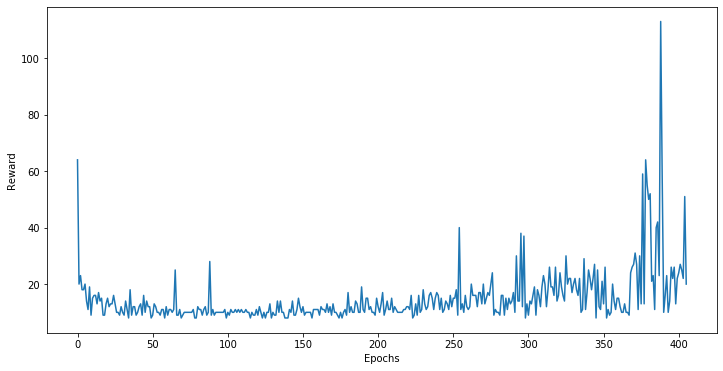

In [255]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(history)
plt.show()

# Testing

In [256]:
for i in range(10):
    state = env.reset()
    scores = 0
    while True:
        env.render()
        action = agent.act(state, 0)
        #print(action)
        state, reward, done, _ = env.step(action)
        #print("step")
        scores += reward
        if done:
            #print("over")
            break
    print("Episode {} | Score {}".format(i, scores))
env.close()        

Episode 0 | Score 45.0
Episode 1 | Score 47.0
Episode 2 | Score 47.0
Episode 3 | Score 40.0
Episode 4 | Score 42.0
Episode 5 | Score 116.0
Episode 6 | Score 43.0
Episode 7 | Score 53.0
Episode 8 | Score 35.0
Episode 9 | Score 57.0


## Eps annealing

In [172]:
eps = 1
eps_start = 1
min_eps = 0.05
eps_frames = 1500
frames = 10000
loggs = []
for frame in range(frames):
    if frame < eps_frames:
        eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
    else:
        eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.0001)
    loggs.append(eps)

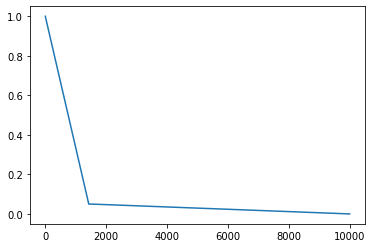

In [173]:
plt.plot(loggs)